Classical approach https://www.youtube.com/watch?v=uJHcULXF1HE

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py

In [33]:
path = "NoCracK/Simple_Homogeneous/Event0000/output.h5"

hf = h5py.File(path, 'r')

In [40]:
selected_ts = 50
t_s = 1e-7

loc = hf['coordinates_ACOUSTIC'][:].reshape(hf['coordinates_ACOUSTIC'][:].shape[0]*hf['coordinates_ACOUSTIC'][:].shape[1],2)

df = pd.DataFrame(columns={'X','Y'})
df['X'] = loc[:,0]
df['Y'] = loc[:,1]
df['X'] = np.round(df['X'],5)
df['Y'] = np.round(df['Y'],5)

values = hf['volume']['phi'][selected_ts,:,:,:25].reshape(2500*25)

df['PHI'] = values
df['T'] = selected_ts * t_s

df_clean = df.loc[::25].pivot_table(values='PHI',index='Y',columns='X')
df_clean.sort_index(axis=0,ascending=False,inplace=True)

In [42]:
df_train_tot = df.loc[::25]

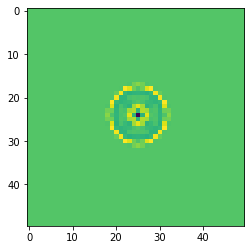

In [43]:
plt.imshow(df_clean.values)

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import time

In [45]:
class PINN(nn.Module):
    def __init__(self,
                in_size = 3, 
                neurons_layer=[32, 32, 32, 32],
                out_size = 1
                ):
        """
        Initializing the PINN
        """
        nn.Module.__init__(self)

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(in_features=in_size, out_features=neurons_layer[0]))
        for n_in, n_out in zip(neurons_layer[:-1], neurons_layer[1:]):
            self.layers.append(nn.Linear(in_features=n_in, out_features=n_out))
        self.out  = nn.Linear(in_features=neurons_layer[-1], out_features=out_size)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward Pass
        """
        for linear in self.layers:
            x = self.relu(linear(x))
        x = self.out(x)
        return x


class PINN_loss(nn.Module):
    def __init__(self, device=None):
        """
        device : self explenatory, cuda if possible 
        """

        nn.Module.__init__(self)

        self.device = device

    def forward(self,p,p_true,x,y,t,c):

        # # # Compute derivatives
        p.requires_grad_(True)

        p_t = torch.sum(self.get_gradient(p, t), dim= 1)
        p_x = torch.sum(self.get_gradient(p, x), dim= 1)
        p_y = torch.sum(self.get_gradient(p, y), dim= 1)

        p_t.requires_grad_(True)
        p_x.requires_grad_(True)
        p_y.requires_grad_(True)

        p_tt = torch.sum(self.get_gradient(p_t, t), dim= 1)
        p_xx = torch.sum(self.get_gradient(p_x, x), dim= 1)
        p_yy = torch.sum(self.get_gradient(p_y, y), dim= 1)

        # # # Wave acoustic equation
        r_p = p_xx + p_yy - 1/(c ** 2) * p_tt 

        # # # Compute loss
        error = torch.mean(torch.square(p - p_true))
        regul = torch.mean(torch.square(r_p))

        print('error',error)
        print('regul',regul)

        return error + regul

    def get_gradient(self, f, x):
        """ computes gradient of tensor f with respect to tensor x """
        assert x.requires_grad_

        x_shape = x.shape
        f_shape = f.shape
        f = f.view(-1)

        x_grads = []
        for f_val in f:
            if x.grad is not None:
                x.grad.data.zero_()
            f_val.backward(retain_graph=True)
            if x.grad is not None:
                x_grads.append(deepcopy(x.grad.data))
            else:
                # in case f isn't a function of x
                x_grads.append(torch.zeros(x.shape).to(x))
        output_shape = list(f_shape) + list(x_shape)
        return torch.cat((x_grads)).view(output_shape)

In [46]:
class Net():
    """
    Net for Acoustic Wave Propagation
    """
    def __init__(self, model, loss, data_train, data_test):
        
        self.x = data_train['x']
        self.y = data_train['y']
        self.t = data_train['t']
        self.p_true = data_train['p_true']

        self.model = model
        self.loss = loss
    def train(self):
        X = torch.stack((self.x, self.y, self.t), 1)

        p = self.model(X)

In [63]:
data_max = df_train_tot.shape[0]

In [72]:
idx = np.random.randint(0,data_max,size=1000)

In [73]:
df_train_tot = df_train_tot.reset_index(drop=True)

In [74]:
df_train = df_train_tot.loc[idx,:].reset_index(drop=True)

In [75]:
class PINNDataset(Dataset):
    def __init__(self, df):
        super(Dataset, self).__init__()

        self.df = df

    def __len__(self):
        return self.df.shape[0]
        
    def __getitem__(self, index):

        # X 
        x = torch.tensor(self.df.loc[index,'X']).float()
        y = torch.tensor(self.df.loc[index,'Y']).float()
        t = torch.tensor(self.df.loc[index,'T']).float()

        # Y
        p = self.df.loc[index,'PHI']

        return x, y, t, p

In [76]:
df_train

,X,Y,PHI,T
0,0.060,0.175,-1.952819e-20,0.000005
1,0.155,0.175,1.331143e-08,0.000005
2,0.145,0.195,-1.429638e-12,0.000005
3,0.060,0.060,2.851429e-25,0.000005
4,0.030,0.240,0.000000e+00,0.000005
...,...,...,...,...
995,0.060,0.220,0.000000e+00,0.000005
996,0.020,0.080,-3.034643e-34,0.000005
997,0.200,0.245,0.000000e+00,0.000005
998,0.065,0.185,1.387116e-21,0.000005


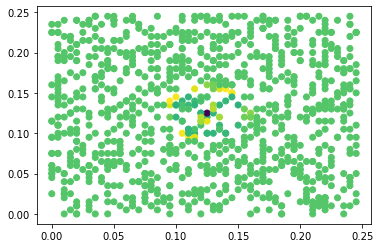

In [77]:
plt.scatter(df_train['X'].values,df_train['Y'].values,c=df_train['PHI'].values)

In [13]:
epoch = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the model
PINN_net = PINN() 
PINN_net = PINN_net.to(device)
# Prepare the dataset
train_dataset = PINNDataset(df_train)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

# Define the loss function and optimizer
LOSS_net = PINN_loss()
optimizer = torch.optim.Adam(PINN_net.parameters(), lr=1e-4)

t0 = time.time()

for i in range(epoch):

    # Set loss value
    current_loss = 0.0

    # Iterate over training data for every mini batch
    for x,y,t, p_true in trainloader:

        # Concatenate data
        X = torch.stack((x, y, t),1)

        X = X.to(device)
        X.require_grad = True
        p_true = p_true.to(device)

        optimizer.zero_grad() # Zero the gradients

        # Forward
        p_train = PINN_net(X) # Perform forward pass
        loss = LOSS_net(p_train,p_true,x,y,t,c=1) # Compute loss

        # Backward and optimize 
        loss.backward() # Perform backward pass
        optimizer.step() # Perform optimization

        current_loss += loss.item()

    t1 = time.time()
    ### Training status
    print('Epoch %d, Loss= %.10f, Time= %.4f' % (i, current_loss, t1-t0))

tensor(0.)
error tensor(49.0974, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(0.1828, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(0.7298, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(0.5420, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(75.8675, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(3.9618, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(0.0433, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(9.3185, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(27.4687, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(102.5747, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(0.0453, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(0.1492, device='cuda:0', grad_fn=<MeanBackward0>)
regul tensor(0.)
error tensor(0.0461, dev

In [79]:
# Validation Set
x = torch.tensor(df_train_tot.loc[:,'X']).float()
y = torch.tensor(df_train_tot.loc[:,'Y']).float()
t = torch.tensor(df_train_tot.loc[:,'T']).float()

X = torch.stack((x, y, t),1)

X = X.to(device)

In [80]:
p_preds = PINN_net(X)

In [82]:
df_train_tot['p_pred'] = p_preds.cpu().detach().numpy() 

In [83]:
df_preds = df_train_tot.pivot_table(values='p_pred',index='Y',columns='X')
df_preds.sort_index(axis=0,ascending=False,inplace=True)

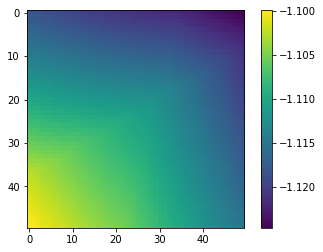

In [84]:
plt.imshow(df_preds.values)
plt.colorbar()